In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install diffusers transformers accelerate datasets
!pip install safetensors
!pip install diffusers transformers datasets torch torchvision pillow accelerate
!pip install controlnet_aux
!pip install --upgrade huggingface_hub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 75.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 70.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 34.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import torch
from diffusers import StableDiffusionPipeline, UNet2DConditionModel, DDPMScheduler
from transformers import CLIPTextModel, CLIPTokenizer
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import json
import torch
from diffusers import StableDiffusionPipeline, UNet2DConditionModel, AutoencoderKL, ControlNetModel, UniPCMultistepScheduler, StableDiffusionControlNetPipeline, DPMSolverMultistepScheduler, AutoPipelineForText2Image
import torch.nn as nn
from controlnet_aux import OpenposeDetector
from diffusers.models.attention_processor import LoRAAttnProcessor

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

/usr/local/lib/python3.11/dist-packages/controlnet_aux/mediapipe_face/mediapipe_face_common.py:7: UserWarning: The module 'mediapipe' is not installed. The package will have limited functionality. Please install it using the command: pip install 'mediapipe'
  warnings.warn(


In [ ]:
import os
drive_path = '/content/drive/MyDrive/BigProject'
work_dir = '/content'

import shutil
import zipfile

# 압축 파일 경로
zip_files = ['Json.zip', 'Img.zip']

# 압축 해제
for zip_file in zip_files:
    zip_path = os.path.join(drive_path, zip_file)  # 압축 파일 경로
    folder_name = os.path.splitext(zip_file)[0]   # 파일명에서 확장자 제거
    extract_folder = os.path.join(work_dir, folder_name)  # 작업 디렉터리 내 폴더 경로
    os.makedirs(extract_folder, exist_ok=True)  # 폴더 생성

    # 압축 해제
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_folder)
        print(f"Extracted {zip_file} to {extract_folder}")

Extracted Json.zip to /content/Json
Extracted Img.zip to /content/Img


In [ ]:
import os
import json

# JSON 파일이 저장된 디렉토리 경로
json_directory = '/content/Json'

# 삭제된 파일 수를 추적하기 위한 변수
deleted_count = 0

# 디렉토리 내의 모든 파일을 확인
for filename in os.listdir(json_directory):
    if filename.endswith('.json'):
        file_path = os.path.join(json_directory, filename)
        try:
            with open(file_path, 'r', encoding='utf-8') as file:
                data = json.load(file)
                # 'label' 및 'directing' 키가 존재하는지 확인
                if 'label' in data and 'directing' in data['label']:
                    directing = data['label']['directing']
                    # 'context' 키가 존재하면 파일 삭제
                    if 'context' in directing:
                        os.remove(file_path)
                        deleted_count += 1
                        print(f"Deleted {file_path}")
        except (json.JSONDecodeError, UnicodeDecodeError) as e:
            print(f"Error reading {file_path}: {e}")

# 남아있는 JSON 파일 목록 가져오기
remaining_files = [f for f in os.listdir(json_directory) if f.endswith('.json')]

remaining_files_path = '/content/drive/MyDrive/BigProject/remainings'

# 남아있는 파일 목록 저장
with open(remaining_files_path, 'w', encoding='utf-8') as file:
    json.dump(remaining_files, file, ensure_ascii=False, indent=4)

# 남아있는 파일 개수 출력
print(f"Remaining JSON files: {len(remaining_files)}")
print(f"Deleted JSON files: {deleted_count}")

Deleted /content/Json/LD115012.json
Deleted /content/Json/LF114173.json
Deleted /content/Json/LD114943.json
Deleted /content/Json/LF127068.json
Deleted /content/Json/LD118985.json
Deleted /content/Json/LF114413.json
Deleted /content/Json/LL022546.json
Deleted /content/Json/LF123590.json
Deleted /content/Json/LD118755.json
Deleted /content/Json/LF123672.json
Deleted /content/Json/LF132650.json
Deleted /content/Json/LF116151.json
Deleted /content/Json/LD113571.json
Deleted /content/Json/LF133719.json
Deleted /content/Json/LF025046.json
Deleted /content/Json/LL022426.json
Deleted /content/Json/LD113787.json
Deleted /content/Json/LD114884.json
Deleted /content/Json/LD113947.json
Deleted /content/Json/LF115881.json
Deleted /content/Json/LF114503.json
Deleted /content/Json/LF123646.json
Deleted /content/Json/LD115103.json
Deleted /content/Json/LF116209.json
Deleted /content/Json/LD118739.json
Deleted /content/Json/LF126785.json
Deleted /content/Json/LD113884.json
Deleted /content/Json/LF1145

In [ ]:
import os
import json
from PIL import Image

# 폴더 경로 설정
json_folder = '/content/Json'
jpg_folder = '/content/Img'

# JSON과 JPG 파일 리스트 가져오기
json_files = [f for f in os.listdir(json_folder) if f.endswith('.json')]
jpg_files = [f for f in os.listdir(jpg_folder) if f.endswith('.JPEG')]

# 숫자 6자리 추출 함수
def extract_suffix(filename):
    return filename[-11:-4]  # 파일명 끝 6자리(확장자 앞)

# JSON과 JPG 매칭
matched_files = []
for json_file in json_files:
    json_suffix = extract_suffix(json_file)
    for jpg_file in jpg_files:
        jpg_suffix = extract_suffix(jpg_file)
        if json_suffix == jpg_suffix:
            matched_files.append((os.path.join(json_folder, json_file), os.path.join(jpg_folder, jpg_file)))

print(f"Matched Files: {len(matched_files)} pairs found.")

Matched Files: 1938 pairs found.


In [ ]:
processed_data = []
for json_path, jpg_path in matched_files:
    # JSON 파일 로드
    with open(json_path, 'r') as f:
        json_data = json.load(f)

    # prompt와 caption 추출
    prompt = json_data["label"].get("prompt", None)
    caption = json_data.get("caption", None)

    # 결과 저장
    processed_data.append({
        "json_path": json_path,
        "jpg_path": jpg_path,
        "prompt": prompt,
        "caption": caption
    })

# 처리된 데이터 개수 출력
print(f"Processed {len(processed_data)} JSON files.")

# 처리된 데이터 예시 출력
for item in processed_data[:3]:  # 처음 3개만 출력
    print(f"JSON Path: {item['json_path']}")
    print(f"Image Path: {item['jpg_path']}")
    print(f"Prompt: {item['prompt']}")
    print(f"Caption: {item['caption']}")
    print("---")

Processed 1938 JSON files.
JSON Path: /content/Json/LL032844.json
Image Path: /content/Img/SL032844.JPEG
Prompt: Men, main characters, middle -aged, humans, and aesthetic, slim, expressionless, short hair, beard, mustache, Background, outdoor, wasteland/desert/land
Caption: Wearing a straw hat, short -sleeved tee, a middle -aged man with a mustache and a mustache, is facing the left with an expressionless face on the ground.
---
JSON Path: /content/Json/LF123369.json
Image Path: /content/Img/SF123369.JPEG
Prompt: Men, masters, young people, human, slaughter, slim, angry
Caption: A man in a short -haired black jacket is walking.
---
JSON Path: /content/Json/LG171132.json
Image Path: /content/Img/SG171132.JPEG
Prompt: Men, main characters, young people, humans, slaughter, slim, angry, short hair
Caption: A man wearing a suit stands on another man sitting in a chair and looks down at another man with a stern look.
---


In [ ]:
from torch.utils.data import Dataset
from PIL import Image
import torch

class ProcessedDataDataset(Dataset):
    def __init__(self, processed_data, transform=None):
        self.data = processed_data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]

        # 이미지 로드
        image = Image.open(sample['jpg_path']).convert("RGB")
        if self.transform:
            image = self.transform(image)

        # 프롬프트와 캡션 로드
        prompt = sample['prompt']
        caption = sample['caption']

        return image, prompt, caption

In [ ]:

# 이미지 변환 정의
from torchvision import transforms
from torch.utils.data import DataLoader, random_split

# 이미지 변환 정의
transform = transforms.Compose([
    transforms.Resize((512, 512)),  # Stable Diffusion 기본 해상도
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # [-1, 1] 범위로 정규화
])

# 전체 데이터셋 생성
full_dataset = ProcessedDataDataset(processed_data, transform=transform)

# 데이터셋 분할 (90% 훈련, 10% 검증)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# 데이터로더 초기화
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False)

print(f"Training data size: {len(train_dataset)}")
print(f"Validation data size: {len(val_dataset)}")

Training data size: 1550
Validation data size: 388


In [ ]:
import torch
from diffusers import StableDiffusionPipeline, UNet2DConditionModel, AutoencoderKL
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

pipeline = StableDiffusionPipeline.from_pretrained(
    "stablediffusionapi/anything-v5"
).to(device)

# UNet 레이어 고정
for param in pipeline.unet.parameters():
    param.requires_grad = False

In [ ]:
# 학습할 레이어 이름 지정
trainable_layers = [
    'down_blocks.1.attentions',
    'down_blocks.1.resnets.0.norm1',
    'down_blocks.1.resnets.0.conv1',
    'down_blocks.1.resnets.0.norm2',
    'down_blocks.1.resnets.0.conv2',
    'down_blocks.1.resnets.1.norm1',
    'down_blocks.1.resnets.1.conv1',
    'down_blocks.1.resnets.1.norm2',
    'down_blocks.1.resnets.1.conv2',
    'down_blocks.2.attentions',
    'down_blocks.2.resnets.0.norm1',
    'down_blocks.2.resnets.0.conv1',
    'down_blocks.2.resnets.0.norm2',
    'down_blocks.2.resnets.0.conv2',
    'down_blocks.2.resnets.1.norm1',
    'down_blocks.2.resnets.1.conv1',
    'down_blocks.2.resnets.1.norm2',
    'down_blocks.2.resnets.1.conv2',
    'up_blocks.1.attentions',
    'up_blocks.0.resnets.0.norm1',
    'up_blocks.0.resnets.0.conv1',
    'up_blocks.0.resnets.0.norm2',
    'up_blocks.0.resnets.0.conv2',
    'up_blocks.0.resnets.1.norm1',
    'up_blocks.0.resnets.1.conv1',
    'up_blocks.0.resnets.1.norm2',
    'up_blocks.0.resnets.1.conv2',
    'up_blocks.0.resnets.2.norm1',
    'up_blocks.0.resnets.2.conv1',
    'up_blocks.0.resnets.2.norm2',
    'up_blocks.0.resnets.2.conv2',
    'up_blocks.1.resnets.0.norm1',
    'up_blocks.1.resnets.0.conv1',
    'up_blocks.1.resnets.0.norm2',
    'up_blocks.1.resnets.0.conv2',
    'up_blocks.1.resnets.1.norm1',
    'up_blocks.1.resnets.1.conv1',
    'up_blocks.1.resnets.1.norm2',
    'up_blocks.1.resnets.1.conv2',
    'up_blocks.1.resnets.2.norm1',
    'up_blocks.1.resnets.2.conv1',
    'up_blocks.1.resnets.2.norm2',
    'up_blocks.2.attentions',
    'up_blocks.1.resnets.2.conv2',
    'up_blocks.2.resnets.0.norm1',
    'up_blocks.2.resnets.0.conv1',
    'up_blocks.2.resnets.0.norm2',
    'up_blocks.2.resnets.0.conv2',
    'up_blocks.2.resnets.1.norm1',
    'up_blocks.2.resnets.1.conv1',
    'up_blocks.2.resnets.1.norm2',
    'up_blocks.2.resnets.1.conv2',
    'up_blocks.2.resnets.2.norm1',
    'up_blocks.2.resnets.2.conv1',
    'up_blocks.2.resnets.2.norm2',
    'up_blocks.2.resnets.2.conv2',
    'mid_block.attentions',
    'mid_block.resnets.0.norm1',
    'mid_block.resnets.0.conv1',
    'mid_block.resnets.0.norm2',
    'mid_block.resnets.0.conv2',
    'mid_block.resnets.1.norm1',
    'mid_block.resnets.1.conv1',
    'mid_block.resnets.1.norm2',
    'mid_block.resnets.1.conv2'
                    ]

# 지정한 레이어의 파라미터만 requires_grad를 True로 설정
for name, param in pipeline.unet.named_parameters():
    if any(layer in name for layer in trainable_layers):
        param.requires_grad = True

In [ ]:
from torch.optim import AdamW
from torch.cuda.amp import GradScaler, autocast
from torch.optim.lr_scheduler import CosineAnnealingLR
from transformers import get_cosine_schedule_with_warmup

num_epochs = 10
learning_rate = 5e-5
grad_accumulation_steps = 4

optimizer = AdamW(filter(lambda p: p.requires_grad, pipeline.unet.parameters()), lr=learning_rate)
num_training_steps = len(train_dataloader) * num_epochs
num_warmup_steps = len(train_dataloader)

scheduler = get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=num_training_steps
)
scaler = GradScaler()

<ipython-input-12-13213425011f>:19: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [ ]:
import torch
torch.cuda.empty_cache()

In [ ]:
from tqdm import tqdm

# 가중치를 저장할 디렉토리 생성
save_dir = "/content/drive/MyDrive/model_checkpoints"
os.makedirs(save_dir, exist_ok=True)
def validate(model, val_dataloader, device):
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for batch in tqdm(val_dataloader, desc="Validating"):
            images, prompts, captions = batch
            images = images.to(device)

            combined_texts = [f"{prompt}. {caption}." for prompt, caption in zip(prompts, captions)]

            # 텍스트 인코딩
            inputs = pipeline.tokenizer(
                combined_texts,
                padding="max_length",
                return_tensors="pt",
                truncation=True,
                max_length=77
            ).to(device)
            text_embeddings = pipeline.text_encoder(input_ids=inputs.input_ids).last_hidden_state

            # 이미지 -> 잠재 공간 인코딩
            latent_images = pipeline.vae.encode(images).latent_dist.sample() * 0.18215

            # 노이즈 추가
            noise = torch.randn_like(latent_images)
            timesteps = torch.randint(0, pipeline.scheduler.config.num_train_timesteps, (latent_images.shape[0],), device=device).long()
            noisy_latents = pipeline.scheduler.add_noise(latent_images, noise, timesteps)

            # UNet 예측 및 손실 계산
            with torch.amp.autocast('cuda'):
                predicted_noise = model(noisy_latents, timesteps, text_embeddings).sample
                val_loss = nn.functional.mse_loss(predicted_noise, noise)

            total_val_loss += val_loss.item()

    avg_val_loss = total_val_loss / len(val_dataloader)
    return avg_val_loss

best_val_loss = float('inf')
for epoch in range(num_epochs):
    pipeline.unet.train()
    total_train_loss = 0
    for step, batch in enumerate(tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")):
        images, prompts, captions = batch
        images = images.to(device)
        combined_texts = [f"{prompt}. {caption}." for prompt, caption in zip(prompts, captions)]
        inputs = pipeline.tokenizer(
            combined_texts,
            padding="max_length",
            return_tensors="pt",
            truncation=True,
            max_length=77
        ).to(device)
        text_embeddings = pipeline.text_encoder(input_ids=inputs.input_ids).last_hidden_state
        with torch.no_grad():
            latent_images = pipeline.vae.encode(images).latent_dist.sample() * 0.18215
        noise = torch.randn_like(latent_images)
        timesteps = torch.randint(0, pipeline.scheduler.config.num_train_timesteps, (latent_images.shape[0],), device=device).long()
        noisy_latents = pipeline.scheduler.add_noise(latent_images, noise, timesteps)
        with torch.cuda.amp.autocast():
            predicted_noise = pipeline.unet(noisy_latents, timesteps, text_embeddings).sample
            loss = nn.functional.mse_loss(predicted_noise, noise)
        scaler.scale(loss).backward()
        if (step + 1) % grad_accumulation_steps == 0:
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(pipeline.unet.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_dataloader)
    avg_val_loss = validate(pipeline.unet, val_dataloader, device)
    print(f"Epoch {epoch + 1} completed. Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        checkpoint_path = os.path.join(save_dir, f"best_model.pth")
        torch.save(pipeline.unet.state_dict(), checkpoint_path)
        print(f"New best model saved to {checkpoint_path}")

    checkpoint_path = os.path.join(save_dir, f"model_epoch_{epoch + 1}.pth")
    torch.save(pipeline.unet.state_dict(), checkpoint_path)

    scheduler.step()

print("Training completed!")

Epoch 1/10:   0%|          | 0/124 [00:00<?, ?it/s]<ipython-input-14-474e0b1a0533>:65: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validating: 100%|██████████| 31/31 [00:41<00:00,  1.33s/it]


Epoch 1 completed. Train Loss: 0.1251, Val Loss: 0.1316
New best model saved to /content/drive/MyDrive/model_checkpoints/best_model.pth


Validating: 100%|██████████| 31/31 [00:41<00:00,  1.33s/it]


Epoch 2 completed. Train Loss: 0.1386, Val Loss: 0.1315
New best model saved to /content/drive/MyDrive/model_checkpoints/best_model.pth


Validating: 100%|██████████| 31/31 [00:41<00:00,  1.33s/it]


Epoch 3 completed. Train Loss: 0.1256, Val Loss: 0.1323


Validating: 100%|██████████| 31/31 [00:41<00:00,  1.33s/it]


Epoch 4 completed. Train Loss: 0.1317, Val Loss: 0.1222
New best model saved to /content/drive/MyDrive/model_checkpoints/best_model.pth


Validating: 100%|██████████| 31/31 [00:41<00:00,  1.34s/it]


Epoch 5 completed. Train Loss: 0.1256, Val Loss: 0.1269


Validating: 100%|██████████| 31/31 [00:41<00:00,  1.33s/it]


Epoch 6 completed. Train Loss: 0.1275, Val Loss: 0.1217
New best model saved to /content/drive/MyDrive/model_checkpoints/best_model.pth


Validating: 100%|██████████| 31/31 [00:41<00:00,  1.33s/it]


Epoch 7 completed. Train Loss: 0.1311, Val Loss: 0.1265


Validating: 100%|██████████| 31/31 [00:41<00:00,  1.33s/it]


Epoch 8 completed. Train Loss: 0.1300, Val Loss: 0.1339


Validating: 100%|██████████| 31/31 [00:41<00:00,  1.34s/it]


Epoch 9 completed. Train Loss: 0.1269, Val Loss: 0.1199
New best model saved to /content/drive/MyDrive/model_checkpoints/best_model.pth


Validating: 100%|██████████| 31/31 [00:41<00:00,  1.34s/it]


Epoch 10 completed. Train Loss: 0.1254, Val Loss: 0.1328
Training completed!


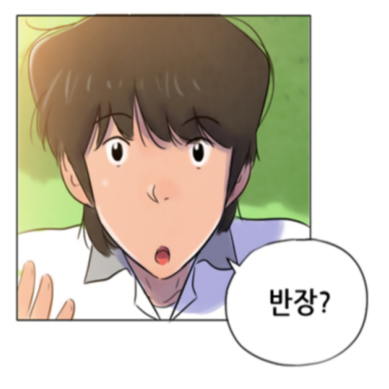

Prompt: 남성,주인물,청년,인간,살구색,날씬한,무표정,짧은 머리,각진형,둥근 눈,둥근 귀,얇은 입술,정면을 향하는,정면을 보는,보다,와이셔츠,배경 있음,실외,초원,아이레벨,전면조명,미디엄 샷
Caption: 와이셔츠를 입은 짧은 머리, 살구색 피부의 청년 남성이 초원에서 무표정으로 정면을 보고있다.
dialogue: 반장?
bubble: 원형/곡선


In [ ]:
# 데이터셋에서 특정 샘플 확인
dataset = ProcessedDataDataset(processed_data, transform=transform)

# 첫 번째 샘플 확인
sample_idx = 5
image, prompt, caption, dialogue, bubble = dataset[sample_idx]

# 이미지 출력
import matplotlib.pyplot as plt
plt.imshow(image.permute(1, 2, 0).numpy() * 0.5 + 0.5)  # [-1, 1]에서 [0, 1] 범위로 변환
plt.axis("off")
plt.show()

# 텍스트 데이터 확인
print(f"Prompt: {prompt}")
print(f"Caption: {caption}")
print(f"dialogue: {dialogue}")
print(f"bubble: {bubble}")

In [ ]:
#Unet 레이어 이름 확
for name, param in pipeline.unet.named_parameters():
    print(f"{name} dtype: {param.dtype}")

conv_in.weight dtype: torch.float16
conv_in.bias dtype: torch.float16
time_embedding.linear_1.weight dtype: torch.float16
time_embedding.linear_1.bias dtype: torch.float16
time_embedding.linear_2.weight dtype: torch.float16
time_embedding.linear_2.bias dtype: torch.float16
down_blocks.0.attentions.0.norm.weight dtype: torch.float16
down_blocks.0.attentions.0.norm.bias dtype: torch.float16
down_blocks.0.attentions.0.proj_in.weight dtype: torch.float16
down_blocks.0.attentions.0.proj_in.bias dtype: torch.float16
down_blocks.0.attentions.0.transformer_blocks.0.norm1.weight dtype: torch.float16
down_blocks.0.attentions.0.transformer_blocks.0.norm1.bias dtype: torch.float16
down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_q.weight dtype: torch.float16
down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_k.weight dtype: torch.float16
down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_v.weight dtype: torch.float16
down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_out.